In [1]:
!pip install pytorch-pretrained-biggan


     |████████████████████████████████| 132 kB 7.3 MB/s 
     |████████████████████████████████| 79 kB 8.6 MB/s 
     |████████████████████████████████| 8.7 MB 53.1 MB/s 
     |████████████████████████████████| 138 kB 57.5 MB/s 
     |████████████████████████████████| 127 kB 54.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
imagenet_path_drive = "/content/drive/MyDrive/Colab Notebooks/CV/project/imagenet"
path_drive = "/content/drive/MyDrive/Colab Notebooks/CV/project/"

In [5]:

def rgb_to_lab(srgb):

	srgb_pixels = torch.reshape(srgb, [-1, 3])

	linear_mask = (srgb_pixels <= 0.04045).type(torch.FloatTensor).cuda()
	exponential_mask = (srgb_pixels > 0.04045).type(torch.FloatTensor).cuda()
	rgb_pixels = (srgb_pixels / 12.92 * linear_mask) + (((srgb_pixels + 0.055) / 1.055) ** 2.4) * exponential_mask
	
	rgb_to_xyz = torch.tensor([
				#    X        Y          Z
				[0.412453, 0.212671, 0.019334], # R
				[0.357580, 0.715160, 0.119193], # G
				[0.180423, 0.072169, 0.950227], # B
			]).type(torch.FloatTensor).cuda()
	
	xyz_pixels = torch.mm(rgb_pixels, rgb_to_xyz)
	

	# XYZ to Lab
	xyz_normalized_pixels = torch.mul(xyz_pixels, torch.tensor([1/0.950456, 1.0, 1/1.088754]).type(torch.FloatTensor).cuda())

	epsilon = 6.0/29.0

	linear_mask = (xyz_normalized_pixels <= (epsilon**3)).type(torch.FloatTensor).cuda()

	exponential_mask = (xyz_normalized_pixels > (epsilon**3)).type(torch.FloatTensor).cuda()

	fxfyfz_pixels = (xyz_normalized_pixels / (3 * epsilon**2) + 4.0/29.0) * linear_mask + ((xyz_normalized_pixels+0.000001) ** (1.0/3.0)) * exponential_mask
	# convert to lab
	fxfyfz_to_lab = torch.tensor([
		#  l       a       b
		[  0.0,  500.0,    0.0], # fx
		[116.0, -500.0,  200.0], # fy
		[  0.0,    0.0, -200.0], # fz
	]).type(torch.FloatTensor).cuda()
	lab_pixels = torch.mm(fxfyfz_pixels, fxfyfz_to_lab) + torch.tensor([-16.0, 0.0, 0.0]).type(torch.FloatTensor).cuda()
	#return tf.reshape(lab_pixels, tf.shape(srgb))
	return torch.reshape(lab_pixels, srgb.shape)


In [6]:
def lab_to_rgb(lab):
		lab_pixels = torch.reshape(lab, [-1, 3])
		# convert to fxfyfz
		lab_to_fxfyfz = torch.tensor([
			#   fx      fy        fz
			[1/116.0, 1/116.0,  1/116.0], # l
			[1/500.0,     0.0,      0.0], # a
			[    0.0,     0.0, -1/200.0], # b
		]).type(torch.FloatTensor).cuda()
		fxfyfz_pixels = torch.mm(lab_pixels + torch.tensor([16.0, 0.0, 0.0]).type(torch.FloatTensor).cuda(), lab_to_fxfyfz)

		# convert to xyz
		epsilon = 6.0/29.0
		linear_mask = (fxfyfz_pixels <= epsilon).type(torch.FloatTensor).cuda()
		exponential_mask = (fxfyfz_pixels > epsilon).type(torch.FloatTensor).cuda()


		xyz_pixels = (3 * epsilon**2 * (fxfyfz_pixels - 4/29.0)) * linear_mask + ((fxfyfz_pixels+0.000001) ** 3) * exponential_mask

		# denormalize for D65 white point
		xyz_pixels = torch.mul(xyz_pixels, torch.tensor([0.950456, 1.0, 1.088754]).type(torch.FloatTensor).cuda())


		xyz_to_rgb = torch.tensor([
			#     r           g          b
			[ 3.2404542, -0.9692660,  0.0556434], # x
			[-1.5371385,  1.8760108, -0.2040259], # y
			[-0.4985314,  0.0415560,  1.0572252], # z
		]).type(torch.FloatTensor).cuda()

		rgb_pixels =  torch.mm(xyz_pixels, xyz_to_rgb)
		# avoid a slightly negative number messing up the conversion
		#clip
		rgb_pixels[rgb_pixels > 1] = 1
		rgb_pixels[rgb_pixels < 0] = 0

		linear_mask = (rgb_pixels <= 0.0031308).type(torch.FloatTensor).cuda()
		exponential_mask = (rgb_pixels > 0.0031308).type(torch.FloatTensor).cuda()
		srgb_pixels = (rgb_pixels * 12.92 * linear_mask) + (((rgb_pixels+0.000001) ** (1/2.4) * 1.055) - 0.055) * exponential_mask
	
		return torch.reshape(srgb_pixels, lab.shape)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import scipy
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy.stats import truncnorm

import nltk
nltk.download('wordnet')

import matplotlib.pyplot as plt
import numpy as np
import copy
import pandas as pd
import PIL 
import pickle 
from tqdm import tqdm

from PIL import Image

import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal)


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Using the GPU!


In [ ]:

%mkdir imagenet 
%cd imagenet 
!tar -xvf "/content/drive/MyDrive/Colab Notebooks/CV/project/ILSVRC2012_img_val.tar"
%cd /content



In [10]:
class INColorDataset(Dataset):
    def __init__(self, subset, fig_size, split, transform=None):

        all_imgs = sorted(glob.glob("/content/imagenet/*"))
        labels = []
        with open(path_drive + "val_gt.txt") as f:
            for line in f:
                labels += [int(line)]

        self.map = self.get_map()

        if(subset == "5k"):
            all_imgs = all_imgs[:5000]
            labels = labels[:5000]
        elif(subset == "10k"):
            all_imgs = all_imgs[:10000]
            labels = labels[:10000]

        all_imgs_size = len(all_imgs)
        if(split == "train"):
            self.imgs = all_imgs[:int(0.6 * all_imgs_size)]
            self.labels = labels[:int(0.6 * all_imgs_size)]
            
        elif(split == "val"):
            self.imgs = all_imgs[int(0.6 * all_imgs_size) : int(0.8 * all_imgs_size)]
            self.labels = labels[int(0.6 * all_imgs_size) : int(0.8 * all_imgs_size)]
        else:
            self.imgs = all_imgs[int(0.8 * all_imgs_size) : ]
            self.labels = labels[int(0.8 * all_imgs_size) : ]
        
        self.transform = transform
        self.fig_size = fig_size

    def __len__(self):
        return len(self.imgs)

    def get_map(self):
        metadata = scipy.io.loadmat(path_drive + "meta.mat",struct_as_record=False)
        synsets = np.squeeze(metadata['synsets'])
        map = {s.ILSVRC2012_ID[0][0] : s.words[0].split(",")[0] for s in synsets[:1000]}
        return map

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path)

        img = img.convert("RGB")


        color_trans = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((self.fig_size, self.fig_size))                                   
        ])

        gray_trans = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((self.fig_size, self.fig_size)),
                transforms.Grayscale(num_output_channels=1)                            
        ])

        label = self.labels[idx]

        label = one_hot_from_names([self.map[label]],batch_size=1).argmax()


        color = color_trans(img)
        gray = gray_trans(img)


        return gray, color, label

In [11]:
def get_dataloader(subset, img_size, split, batch_size=1, num_workers=1):
    '''Use Pytorch torch.utils.data.DataLoader to load batched data'''
    
    dataset = INColorDataset(subset, img_size, split)

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,

    )
    return dataloader



In [ ]:

class ColorNet_inv(nn.Module):

    '''
    BIGGAN: https://github.com/huggingface/pytorch-pretrained-BigGAN
    '''
    def __init__(self, z_dim = 128, out_size = 128):
        super().__init__()

        # self.encoder = self.encoder_setup()
        #self.classifier = self.classifier_setup()

        '''
        FC layers mapping from 2048 (output of encoder) to lower dim for BIGGAN
        '''

        self.gan = BigGAN.from_pretrained(f'biggan-deep-{out_size}')

    def forward(self, x, labels):

        labels = F.one_hot(labels, num_classes=1000).type(torch.float32)
      
        '''
        gan takes three arguments: encoding, class probs, and truncation factor (set to 1 here for no truncation)
        '''
        output = self.gan(x, labels, 1)

        '''
        outputs of BIGGAN images are scaled in [-1, 1], so scale it back to [0,1]
        '''
        norm_output = (output + 1) / 2
        return norm_output
        

In [ ]:
'''
standard training loop
'''
def train_model(model, dataloader, input, optimizer, scheduler = None, num_steps=10000):
    model.train()

    #random image
    g, c, gt = iter(dl).next()
    g = g.to(device)
    c = c.to(device)
    gt = gt.to(device)

    iterator =  tqdm(range(num_steps))
    for step in iterator:

        # zero the parameter gradients
        optimizer.zero_grad()

        out = model(input, gt)
        out_g = transforms.Grayscale(num_output_channels=1)(out)
        loss = nn.MSELoss()(out_g, g)
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()
        
        iterator.set_description("Current Loss ({:.4e})".format(
              loss.item()
          )
        )
    
    return input, g, c, gt

In [ ]:
dl = get_dataloader("5k", 128, "train", batch_size=1, num_workers=1)

colornet = ColorNet_inv().to(device)


In [ ]:
input = torch.randn((1,128)).to(device)
input.requires_grad = True
optimizer = torch.optim.Adam([input], lr = 0.001, betas = (0.5, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10000, gamma = 0.1)

In [ ]:
input, g, c, gt = train_model(colornet, dl, input, optimizer, scheduler = None, num_steps=15000)

Current Loss (7.1759e-03): 100%|██████████| 15000/15000 [29:23<00:00,  8.50it/s]


# Evaluation

In [ ]:
g = g.repeat(1,3,1,1)


torch.Size([1, 1, 128, 128])

In [ ]:
out = None
with torch.no_grad():
    out = colornet(input, gt)
    
    g = g.repeat(1,3,1,1)

    g_LAB = rgb_to_lab(g)
    out_LAB = rgb_to_lab(out)

    out_LAB[:, [0], :, :] = g_LAB[:, [0], :, :]

    final = lab_to_rgb(out_LAB)


fig, ax = plt.subplots(1,3, figsize=(10,30))
#ax[0].imshow(g[0].detach().cpu().numpy().transpose(1,2,0))
ax[1].imshow(final[0].detach().cpu().numpy().transpose(1,2,0))
ax[2].imshow(c[0].detach().cpu().numpy().transpose(1,2,0))

# TEsting

In [ ]:

g, c, gt = iter(dl).next()

In [71]:
noise_vector = torch.zeros(3, 128)
for i in range(3):
    noise_vector[i] = torch.Tensor([ 1.2495,  0.9962,  0.5886,  2.0000, -0.0094, -0.4114,  1.6561,  2.0000,
         0.7573, -1.4558, -1.2729,  1.5168, -0.0783, -2.0000,  1.4104,  1.1196,
         0.4636,  0.4344,  0.6553,  1.1532,  0.0352,  0.9983, -0.8231, -1.4524,
        -1.1595,  0.7835, -0.9351,  0.4199, -2.0000, -1.0421,  0.2418,  2.0000,
         0.8897, -0.9146,  1.6309,  1.4040, -0.7009,  1.5319,  1.2343,  2.0000,
         0.3981,  0.4016, -0.9427,  0.9601,  0.6163, -1.2026, -1.9115,  0.8507,
         0.6039, -2.0000,  0.5870, -2.0000, -0.8715, -1.6479,  1.0984,  2.0000,
         2.0000, -1.4279, -0.0420, -1.7293,  0.9773, -1.9286, -0.5212,  0.6920,
         2.0000, -0.4150, -1.7746,  2.0000, -1.5571,  1.0997,  0.6789,  0.0869,
        -1.6246, -0.5631,  1.8453, -1.3666,  0.0160,  0.8158,  1.0896,  0.8901,
        -1.6948,  0.8029, -1.6151,  2.0000,  0.7544,  0.3221, -1.3631, -1.4448,
        -2.0000, -0.6322,  1.5341, -1.5146, -2.0000,  1.3770, -0.5399,  1.8553,
        -1.4581, -0.7347,  0.9955, -2.0000,  1.6354, -1.4959, -1.2828,  0.4656,
         1.0930, -0.5570,  2.0000,  0.1341, -0.2179, -2.0000, -1.7720, -0.7339,
        -2.0000, -0.8758, -1.6242, -0.7762, -2.0000, -0.2135, -2.0000,  1.8901,
         1.0917, -1.8670,  2.0000, -0.3059,  1.2150, -1.7685,  2.0000,  0.3065])



In [72]:
truncation = 1
class_vector = one_hot_from_names(['assault rifle', 'assault rifle', 'assault rifle'], batch_size=3)
#noise_vector = truncated_noise_sample(truncation=truncation, batch_size=3)
noise_vector = (noise_vector * 0.1).numpy()


# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
model.to('cuda')

# Generate an image
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation)

In [73]:
noise_vector[0]

tensor([ 0.1250,  0.0996,  0.0589,  0.2000, -0.0009, -0.0411,  0.1656,  0.2000,
         0.0757, -0.1456, -0.1273,  0.1517, -0.0078, -0.2000,  0.1410,  0.1120,
         0.0464,  0.0434,  0.0655,  0.1153,  0.0035,  0.0998, -0.0823, -0.1452,
        -0.1160,  0.0784, -0.0935,  0.0420, -0.2000, -0.1042,  0.0242,  0.2000,
         0.0890, -0.0915,  0.1631,  0.1404, -0.0701,  0.1532,  0.1234,  0.2000,
         0.0398,  0.0402, -0.0943,  0.0960,  0.0616, -0.1203, -0.1911,  0.0851,
         0.0604, -0.2000,  0.0587, -0.2000, -0.0872, -0.1648,  0.1098,  0.2000,
         0.2000, -0.1428, -0.0042, -0.1729,  0.0977, -0.1929, -0.0521,  0.0692,
         0.2000, -0.0415, -0.1775,  0.2000, -0.1557,  0.1100,  0.0679,  0.0087,
        -0.1625, -0.0563,  0.1845, -0.1367,  0.0016,  0.0816,  0.1090,  0.0890,
        -0.1695,  0.0803, -0.1615,  0.2000,  0.0754,  0.0322, -0.1363, -0.1445,
        -0.2000, -0.0632,  0.1534, -0.1515, -0.2000,  0.1377, -0.0540,  0.1855,
        -0.1458, -0.0735,  0.0996, -0.20

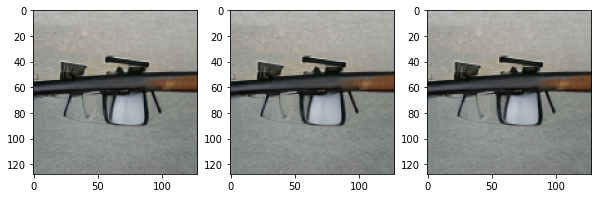

In [74]:
fig, ax = plt.subplots(1,3, figsize=(10,30))
ax[0].imshow(((output[0] + 1) / 2).detach().cpu().numpy().transpose(1,2,0))
ax[1].imshow(((output[1] + 1) / 2).detach().cpu().numpy().transpose(1,2,0))
ax[2].imshow(((output[2] + 1) / 2).detach().cpu().numpy().transpose(1,2,0))